In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from collections import defaultdict
import colorsys
import numpy as np

sns.set_theme(style="darkgrid")

def adjust_lightness(color, factor=1.0):
    rgb = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * factor))
    return colorsys.hls_to_rgb(h, l, s)

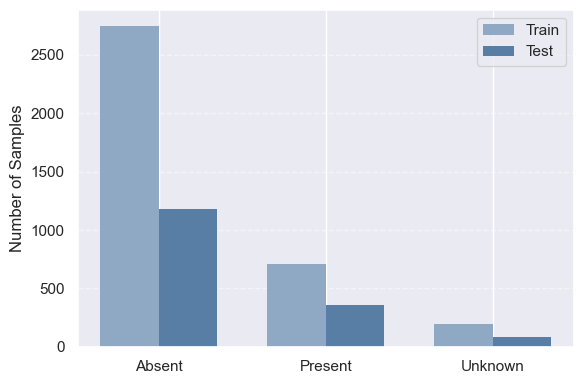

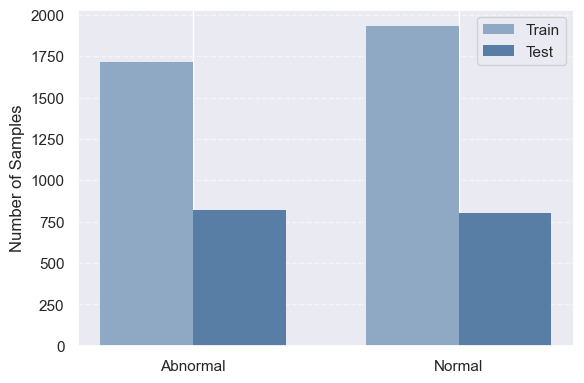

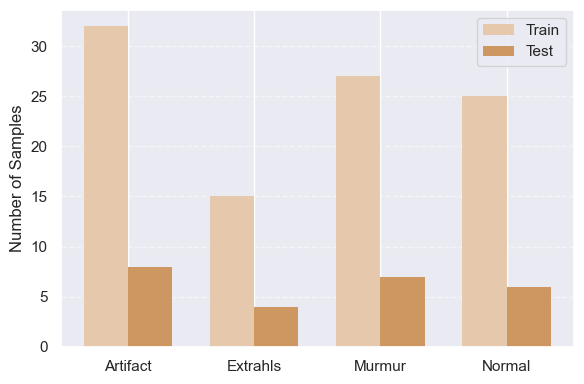

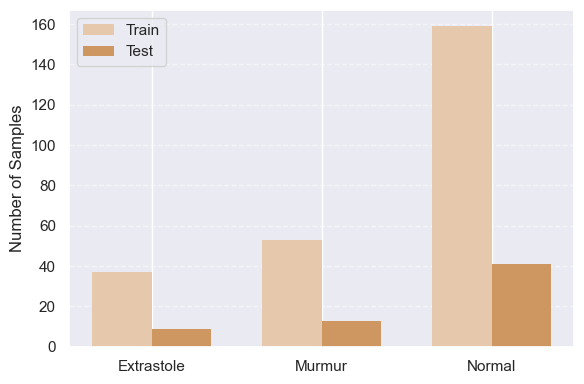

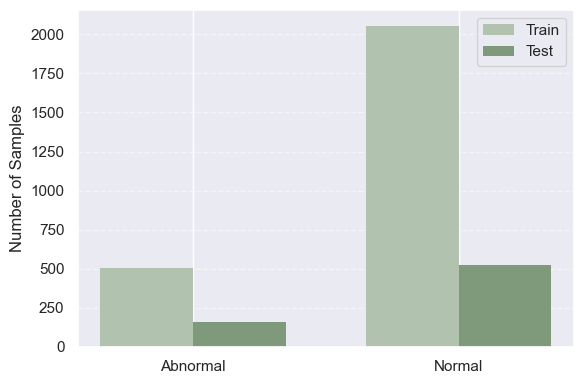

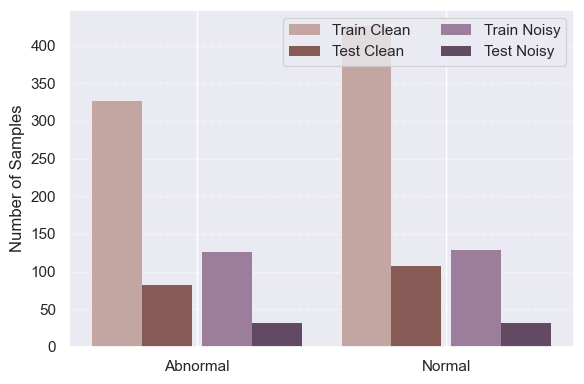

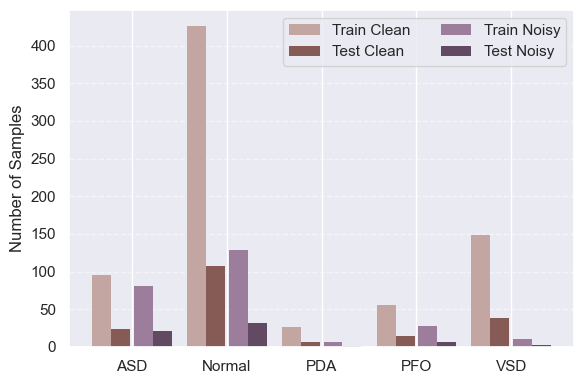

In [ ]:
splits_info = [
    {'dataset': 'CirCor DigiScope', 'task': 'Murmurs',
     'train_distribution': 'Absent: 2748, Present: 708, Unknown: 193',
     'test_distribution': 'Unknown: 85, Absent: 1181, Present: 357'},
    {'dataset': 'CirCor DigiScope', 'task': 'Outcomes',
     'train_distribution': 'Normal: 1935, Abnormal: 1714',
     'test_distribution': 'Normal: 805, Abnormal: 818'},
    {'dataset': 'Pascal A', 'task': 'Murmurs',
     'train_distribution': 'artifact: 32, extrahls: 15, murmur: 27, normal: 25',
     'test_distribution': 'artifact: 8, extrahls: 4, murmur: 7, normal: 6'},
    {'dataset': 'Pascal B', 'task': 'Murmurs',
     'train_distribution': 'extrastole: 37, murmur: 53, normal: 159',
     'test_distribution': 'extrastole: 9, murmur: 13, normal: 41'},
    {'dataset': 'Physionet 2016', 'task': 'Murmurs',
     'train_distribution': 'normal: 2053, abnormal: 507',
     'test_distribution': 'normal: 522, abnormal: 158'},
    {'dataset': 'ZCHSound clean', 'task': 'Murmurs',
     'train_distribution': 'Abnormal: 326, Normal: 426',
     'test_distribution': 'Abnormal: 82, Normal: 107'},
    {'dataset': 'ZCHSound clean', 'task': 'Outcomes',
     'train_distribution': 'VSD: 149, NORMAL: 426, PFO: 56, ASD: 95, PDA: 26',
     'test_distribution': 'VSD: 38, NORMAL: 107, ASD: 24, PFO: 14, PDA: 6'},
    {'dataset': 'ZCHSound noisy', 'task': 'Murmurs',
     'train_distribution': 'Abnormal: 126, Normal: 128',
     'test_distribution': 'Abnormal: 32, Normal: 32'},
    {'dataset': 'ZCHSound noisy', 'task': 'Outcomes',
     'train_distribution': 'ASD: 81, NORMAL: 128, PDA: 6, PFO: 28, VSD: 11',
     'test_distribution': 'PDA: 1, ASD: 21, NORMAL: 32, PFO: 7, VSD: 3'}
]

# Base colors per dataset
base_colors = {
    "CirCor DigiScope": "#6a8caf",
    "Pascal A": "#d6a77a",
    "Pascal B": "#d6a77a",
    "Physionet 2016": "#8fa78c", # #a7bfa3",
    "ZCHSound clean": "#a3756f",
    "ZCHSound noisy": "#7b5e7b",
}

# Group ZCHSound clean + noisy into shared plots
merged_zchsound = defaultdict(lambda: {'clean': {}, 'noisy': {}})

for info in splits_info:
    dataset = info['dataset']
    task = info['task']
    train_dist = dict([tuple(map(str.strip, x.split(":"))) for x in info['train_distribution'].split(",")])
    train_dist = {k.capitalize() if k not in ["PDA", "ASD", "PFO", "VSD"] else k: int(v) for k, v in train_dist.items()}
    test_dist = dict([tuple(map(str.strip, x.split(":"))) for x in info['test_distribution'].split(",")])
    test_dist = {k.capitalize()if k not in ["PDA", "ASD", "PFO", "VSD"] else k: int(v) for k, v in test_dist.items()}

    if "ZCHSound" in dataset:
        key = f"ZCHSound – {task}"
        label = "clean" if "clean" in dataset else "noisy"
        merged_zchsound[key][label]['train'] = train_dist
        merged_zchsound[key][label]['test'] = test_dist
    else:
        labels = sorted(set(train_dist.keys()) | set(test_dist.keys()))
        train = [train_dist.get(lbl, 0) for lbl in labels]
        test = [test_dist.get(lbl, 0) for lbl in labels]

        color = base_colors[dataset]
        fig, ax = plt.subplots(figsize=(6, 4))
        x = range(len(labels))

        bar_width = 0.35
        x = np.arange(len(labels))

        ax.bar(x-bar_width/2, train, width=bar_width, label="Train", color=adjust_lightness(color, 1.2), align='center', edgecolor='none')
        ax.bar(x, test, width=bar_width, label="Test", color=adjust_lightness(color, 0.9), align='edge', edgecolor='none')
        #ax.set_title(f"{dataset} – {task}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylabel("Number of Samples")
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(f"imbalance_plots/{dataset.replace(' ', '_')}-{task}.pdf")
        #plt.close()

# Plot merged ZCHSound
for key, split_data in merged_zchsound.items():
    all_labels = set()
    for subtype in split_data:
        for split in split_data[subtype]:
            all_labels.update(split_data[subtype][split].keys())
    labels = sorted(all_labels)
    x = range(len(labels))

    fig, ax = plt.subplots(figsize=(6, 4))

    for subtype, base in zip(['clean', 'noisy'], ['ZCHSound clean', 'ZCHSound noisy']):
        if not split_data[subtype]:
            continue
        base_color = base_colors[base]
        x = np.arange(len(labels))
        bar_width = 0.2
        gap = 0.12

        # Get counts
        train_clean = [split_data['clean']['train'].get(lbl, 0) for lbl in labels]
        test_clean  = [split_data['clean']['test'].get(lbl, 0) for lbl in labels]
        train_noisy = [split_data['noisy']['train'].get(lbl, 0) for lbl in labels]
        test_noisy  = [split_data['noisy']['test'].get(lbl, 0) for lbl in labels]

        # Base colors
        clean_color = base_colors['ZCHSound clean']
        noisy_color = base_colors['ZCHSound noisy']

        # Plot bars at precise positions
        ax.bar(x - bar_width - gap, train_clean, width=bar_width, label="Train Clean", color=adjust_lightness(clean_color, 1.3), edgecolor="none")
        ax.bar(x - gap,            test_clean,  width=bar_width, label="Test Clean",  color=adjust_lightness(clean_color, 0.8), edgecolor="none")
        ax.bar(x + gap,            train_noisy, width=bar_width, label="Train Noisy", color=adjust_lightness(noisy_color, 1.3), edgecolor="none")
        ax.bar(x + bar_width + gap, test_noisy, width=bar_width, label="Test Noisy",  color=adjust_lightness(noisy_color, 0.8), edgecolor="none")
    #ax.set_title(key)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Number of Samples")
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), ncol=2)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    #plt.savefig(f"imbalance_plots/{key.replace(' ', '_').replace('–', '-')}.pdf")
    #plt.close()


In [ ]:
base_colors = {
    "CirCor DigiScope": "#6a8caf",
    "Pascal A": "#d6a77a",
    "Pascal B": "#d6a77a",
    "Physionet 2016": "#8fa78c", # #a7bfa3",
    "ZCHSound clean": "#a3756f",
    "ZCHSound noisy": "#7b5e7b",
}
for name, color in base_colors.items():
    print(name, mcolors.to_hex(adjust_lightness(color, 0.9)))

CirCor DigiScope #587ea5
Pascal A #ce9660
Pascal B #ce9660
Physionet 2016 #7e9a7b
ZCHSound clean #966660
ZCHSound noisy #6f556f
